<a href="https://colab.research.google.com/github/rul124/Capstone-MSED/blob/main/HubertLarge_Mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1+cu113
0.12.1+cu113
cpu


In [52]:
bundle = torchaudio.pipelines.HUBERT_LARGE
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [53]:
bundle.sample_rate

16000

### Feature Preparation

In [54]:
# Define path to datasets
DATA_NATURAL = "/content/drive/MyDrive/MESD/MESD_All"
entries = os.listdir(DATA_NATURAL)
print("First:", entries[0])

First: Anger_C_B_alterado.wav


In [55]:
sample_file = DATA_NATURAL + "/" + entries[0]
print("Sample file is:", sample_file)
sample_wave, sr = torchaudio.load(sample_file)
sample_wave = sample_wave.to(device)
if sr != bundle.sample_rate:
    sample_wave = torchaudio.functional.resample(sample_wave, sr, bundle.sample_rate)

with torch.inference_mode():
    features, _ = model.extract_features(sample_wave)

Sample file is: /content/drive/MyDrive/MESD/MESD_All/Anger_C_B_alterado.wav


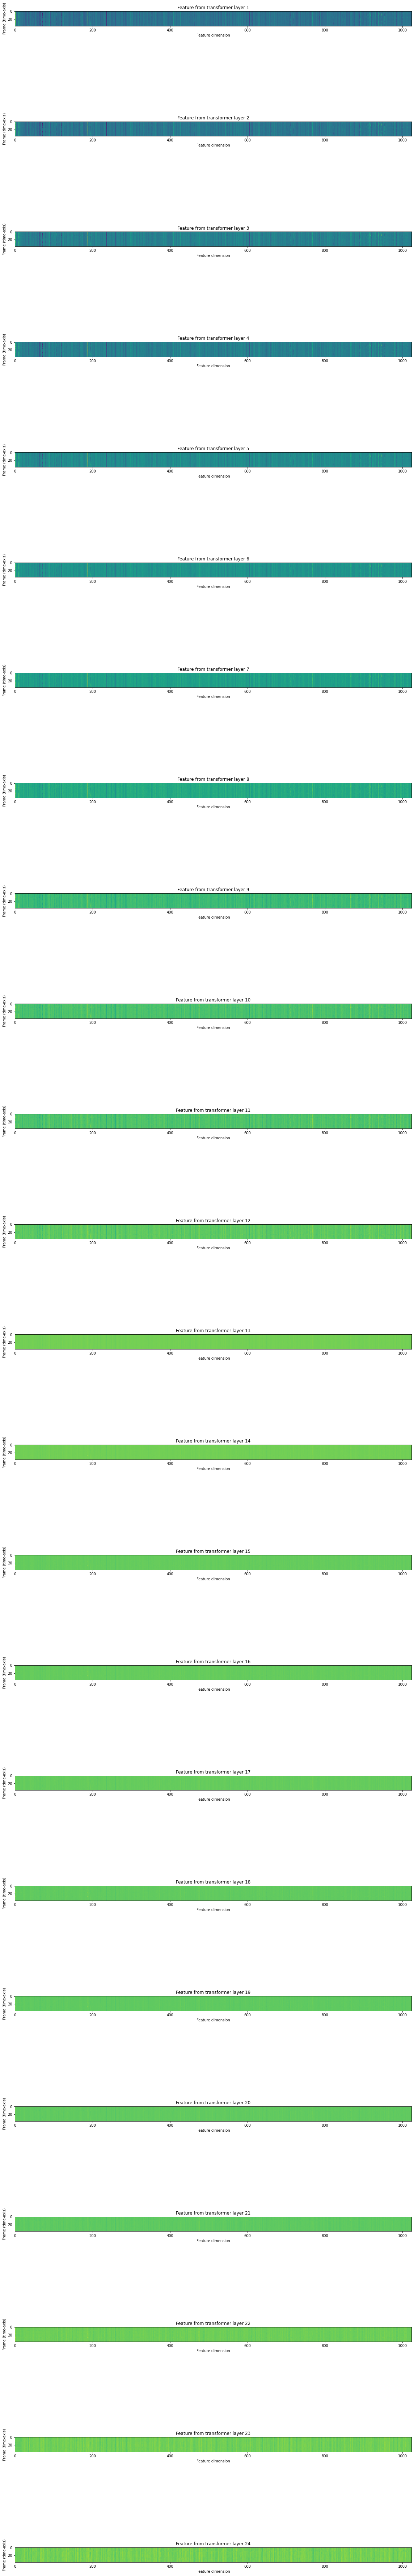

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [57]:
audios = []
labels = []

from tqdm import tqdm

for i in tqdm(range(len(entries))):
    entry = entries[i]
    path = DATA_NATURAL + "/" + entry
    if "wav" not in path:
      continue
    label = entry.split("_")[0]
    labels.append(label)
    wave, sr = torchaudio.load(path)
    wave = wave.to(device)
    if sr != bundle.sample_rate:
      wave = torchaudio.functional.resample(wave, sr, bundle.sample_rate)
    with torch.inference_mode():
      features, _ = model.extract_features(wave)
    audios.append(torch.mean(torch.stack(features), dim=0)[0])

100%|██████████| 863/863 [11:10<00:00,  1.29it/s]


In [58]:
print(f'First audio shape: {audios[0].shape}')
print(f'First audio size: {audios[0].size(0)}')
print(f'Last audio torch size: {audios[-1].shape}')

First audio shape: torch.Size([38, 1024])
First audio size: 38
Last audio torch size: torch.Size([43, 1024])


In [59]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, data, label, label_transform):
        super(MyDataSet).__init__()
        self.data = data
        self.label = label
        self.label_transform = label_transform
        
    def __getitem__(self, idx):
        audio = self.data[idx]
        label = self.label_transform[self.label[idx]]
        length = self.data[idx].size(0)
        return audio, length, label
    
    def __len__(self):
        return len(self.label)

In [60]:
categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Neutral']
cate_dic = {}
for i, cate in enumerate(categories):
    cate_dic[cate] = i
cate_dic

{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happiness': 3,
 'Sadness': 4,
 'Neutral': 5}

In [61]:

def collate_indic(data):

    _, lengths, labels = zip(*data)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    return features, lengths, labels

In [62]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(audios, labels, 
                                                    test_size=0.2, 
                                                    random_state=4800)

train_dataset = MyDataSet(X_train, y_train, cate_dic)
trainloader_args = dict(batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, **trainloader_args, 
                              collate_fn=collate_indic)

test_dataset = MyDataSet(X_test, y_test, cate_dic)
testloader_args = dict(batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, **testloader_args, 
                             collate_fn=collate_indic)

In [63]:
for batch, data in enumerate(train_dataloader):
    x, length, y = data
    print(batch, x.shape)

0 torch.Size([64, 109, 1024])
1 torch.Size([64, 102, 1024])
2 torch.Size([64, 116, 1024])
3 torch.Size([64, 92, 1024])
4 torch.Size([64, 111, 1024])
5 torch.Size([64, 92, 1024])
6 torch.Size([64, 100, 1024])
7 torch.Size([64, 107, 1024])
8 torch.Size([64, 98, 1024])
9 torch.Size([64, 126, 1024])
10 torch.Size([49, 70, 1024])


## CNN Model Training

In [64]:
import torch.nn as nn
import torch.nn.functional as F

class ICASSP3CNN(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=512, num_lstm_layers = 2, bidirectional = False, label_size=7):
        super().__init__()
        self.n_layers = num_lstm_layers 
        self.hidden = hidden_size
        self.bidirectional = bidirectional
        
        self.embed = nn.Linear(in_features = vocab_size, out_features = embed_size)

        self.cnn  = nn.Conv1d(embed_size, embed_size, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(embed_size, embed_size, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(embed_size, embed_size, kernel_size=7, padding=3)

        self.batchnorm = nn.BatchNorm1d(3 * embed_size)

        self.lstm = nn.LSTM(input_size = 3 * embed_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_lstm_layers, 
                            bidirectional = bidirectional)

        self.linear = nn.Linear(in_features = 2 * hidden_size if bidirectional else hidden_size, 
                                out_features = label_size)


    def forward(self, x, lengths):
        """
        padded_x: (B,T) padded LongTensor
        """

        input = self.embed(x)

        batch_size = input.size(0)
        input = input.transpose(1,2)    # (B,T,H) -> (B,H,T)

        cnn_output = torch.cat([self.cnn(input), self.cnn2(input), self.cnn3(input)], dim=1)

        input = F.relu(self.batchnorm(cnn_output))

        input = input.transpose(1,2)

        pack_tensor = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        _, (hn, cn) = self.lstm(pack_tensor)

        if self.bidirectional:
            h_n = hn.view(self.n_layers, 2, batch_size, self.hidden)
            h_n = torch.cat([ h_n[-1, 0,:], h_n[-1,1,:] ], dim = 1)
        else:
            h_n = hn[-1]

        logits = self.linear(h_n)

        return logits

In [65]:
from torchsummary import summary

model = ICASSP3CNN(1024)

In [66]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
from tqdm import tqdm

epochs = 30
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in tqdm(range(epochs)):
    train_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.train()
    for batch, (x, length, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x, length)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()

        #model outputs
        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    train_loss = train_loss/batch_cnt
    train_accuracy = acc_cnt/(acc_cnt+err_cnt)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    
    valid_loss = 0
    acc_cnt = 0
    err_cnt = 0
    batch_cnt = 0
    model.eval()

    for x, lengths, y in test_dataloader:

        x = x.to(device)
        y = y.to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)
        valid_loss += loss.cpu().item()

        out_val, out_indices = torch.max(logits, dim=1)
        tar_indices = y

        for i in range(len(out_indices)):
            if out_indices[i] == tar_indices[i]:
                acc_cnt += 1
            else:
                err_cnt += 1
        batch_cnt += 1
    
    valid_loss = valid_loss/batch_cnt
    valid_accuracy = acc_cnt/(acc_cnt+err_cnt)
    valid_accuracies.append(valid_accuracy)
    valid_losses.append(valid_loss)
    
    print(f"epoch:{epoch+1}, train accu:{train_accuracy:.4f}, train loss:{train_loss:.2f}, valid accu:{valid_accuracy:.4f}, valid loss:{valid_loss:.2f}")

  3%|▎         | 1/30 [00:55<26:40, 55.17s/it]

epoch:1, train accu:0.2017, train loss:1.83, valid accu:0.1734, valid loss:1.78


  7%|▋         | 2/30 [01:52<26:19, 56.40s/it]

epoch:2, train accu:0.3208, train loss:1.66, valid accu:0.4277, valid loss:1.53


 10%|█         | 3/30 [02:48<25:21, 56.37s/it]

epoch:3, train accu:0.4035, train loss:1.46, valid accu:0.3815, valid loss:1.62


 13%|█▎        | 4/30 [03:45<24:29, 56.54s/it]

epoch:4, train accu:0.4877, train loss:1.28, valid accu:0.4277, valid loss:1.33


 17%|█▋        | 5/30 [04:40<23:22, 56.12s/it]

epoch:5, train accu:0.5573, train loss:1.07, valid accu:0.5145, valid loss:1.19


 20%|██        | 6/30 [05:38<22:39, 56.63s/it]

epoch:6, train accu:0.5907, train loss:0.96, valid accu:0.5549, valid loss:1.19


 23%|██▎       | 7/30 [06:35<21:43, 56.69s/it]

epoch:7, train accu:0.6662, train loss:0.88, valid accu:0.2601, valid loss:3.34


 27%|██▋       | 8/30 [07:30<20:34, 56.12s/it]

epoch:8, train accu:0.6343, train loss:0.93, valid accu:0.4971, valid loss:1.86


 30%|███       | 9/30 [08:24<19:26, 55.56s/it]

epoch:9, train accu:0.6894, train loss:0.78, valid accu:0.5434, valid loss:1.19


 33%|███▎      | 10/30 [09:19<18:27, 55.36s/it]

epoch:10, train accu:0.7184, train loss:0.66, valid accu:0.6012, valid loss:1.13


 37%|███▋      | 11/30 [10:14<17:27, 55.12s/it]

epoch:11, train accu:0.6967, train loss:0.72, valid accu:0.5954, valid loss:0.96


 40%|████      | 12/30 [11:07<16:24, 54.68s/it]

epoch:12, train accu:0.7721, train loss:0.59, valid accu:0.5087, valid loss:1.42


 43%|████▎     | 13/30 [12:01<15:23, 54.33s/it]

epoch:13, train accu:0.8171, train loss:0.48, valid accu:0.5491, valid loss:1.39


 47%|████▋     | 14/30 [12:54<14:24, 54.01s/it]

epoch:14, train accu:0.8273, train loss:0.43, valid accu:0.5434, valid loss:1.42


 50%|█████     | 15/30 [13:51<13:41, 54.79s/it]

epoch:15, train accu:0.8549, train loss:0.40, valid accu:0.5838, valid loss:1.84


 53%|█████▎    | 16/30 [14:48<12:57, 55.53s/it]

epoch:16, train accu:0.8128, train loss:0.45, valid accu:0.4855, valid loss:1.72


 57%|█████▋    | 17/30 [15:46<12:12, 56.31s/it]

epoch:17, train accu:0.7954, train loss:0.56, valid accu:0.4566, valid loss:2.39


 60%|██████    | 18/30 [16:43<11:16, 56.39s/it]

epoch:18, train accu:0.8389, train loss:0.45, valid accu:0.4971, valid loss:1.85


 63%|██████▎   | 19/30 [17:38<10:17, 56.11s/it]

epoch:19, train accu:0.8505, train loss:0.40, valid accu:0.6243, valid loss:1.10


 67%|██████▋   | 20/30 [18:33<09:17, 55.79s/it]

epoch:20, train accu:0.9086, train loss:0.27, valid accu:0.5087, valid loss:2.07


 70%|███████   | 21/30 [19:29<08:21, 55.67s/it]

epoch:21, train accu:0.8970, train loss:0.27, valid accu:0.4913, valid loss:2.26


 73%|███████▎  | 22/30 [20:21<07:18, 54.80s/it]

epoch:22, train accu:0.8752, train loss:0.34, valid accu:0.5838, valid loss:1.59


 77%|███████▋  | 23/30 [21:16<06:22, 54.69s/it]

epoch:23, train accu:0.8650, train loss:0.34, valid accu:0.6994, valid loss:1.09


 80%|████████  | 24/30 [22:11<05:28, 54.75s/it]

epoch:24, train accu:0.9042, train loss:0.26, valid accu:0.6012, valid loss:1.74


 83%|████████▎ | 25/30 [23:06<04:34, 54.83s/it]

epoch:25, train accu:0.9158, train loss:0.24, valid accu:0.4220, valid loss:2.59


 87%|████████▋ | 26/30 [24:02<03:40, 55.24s/it]

epoch:26, train accu:0.8839, train loss:0.31, valid accu:0.4624, valid loss:1.74


 90%|█████████ | 27/30 [24:58<02:46, 55.63s/it]

epoch:27, train accu:0.9086, train loss:0.23, valid accu:0.6185, valid loss:1.45


 93%|█████████▎| 28/30 [25:54<01:50, 55.50s/it]

epoch:28, train accu:0.9390, train loss:0.15, valid accu:0.6127, valid loss:1.63


 97%|█████████▋| 29/30 [26:50<00:55, 55.91s/it]

epoch:29, train accu:0.9478, train loss:0.14, valid accu:0.7514, valid loss:1.11


100%|██████████| 30/30 [27:46<00:00, 55.54s/it]

epoch:30, train accu:0.9361, train loss:0.17, valid accu:0.4393, valid loss:2.84


In [68]:
# model_path = '/content/drive/MyDrive/MESD/hubert_base.pth'

# torch.save({'epoch':epochs,
#             'model_state_dict':model.state_dict(),
#             'optimizer_state_dict':optimizer.state_dict()},
#             model_path)

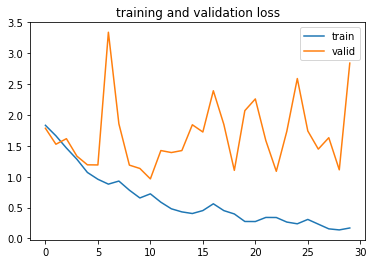

In [69]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), valid_losses, label='valid')
plt.legend()
plt.title('training and validation loss')
plt.show()

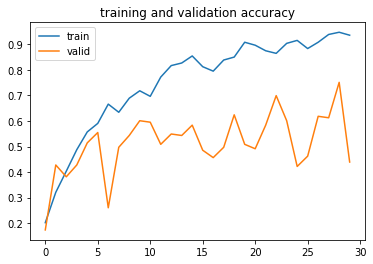

In [70]:
plt.plot(range(epochs), train_accuracies, label='train')
plt.plot(range(epochs), valid_accuracies, label='valid')
plt.legend()
plt.title('training and validation accuracy')
plt.show()

In [71]:
# import pandas as pd
# from datetime import datetime

# now = datetime.now()

# metadata = pd.DataFrame({'epoch':range(epochs), 'train loss':train_losses, 
#                          'valid loss':valid_losses, 
#                          'train accu':train_accuracies, 
#                          'valid_accu':valid_accuracies})
# metadata.to_csv(f'/content/drive/MyDrive/MESD/hubert_base.csv', index=False)